In [1]:
import pandas as pd
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [57]:
df.isna().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

Пропусков нет, что просто замечательно

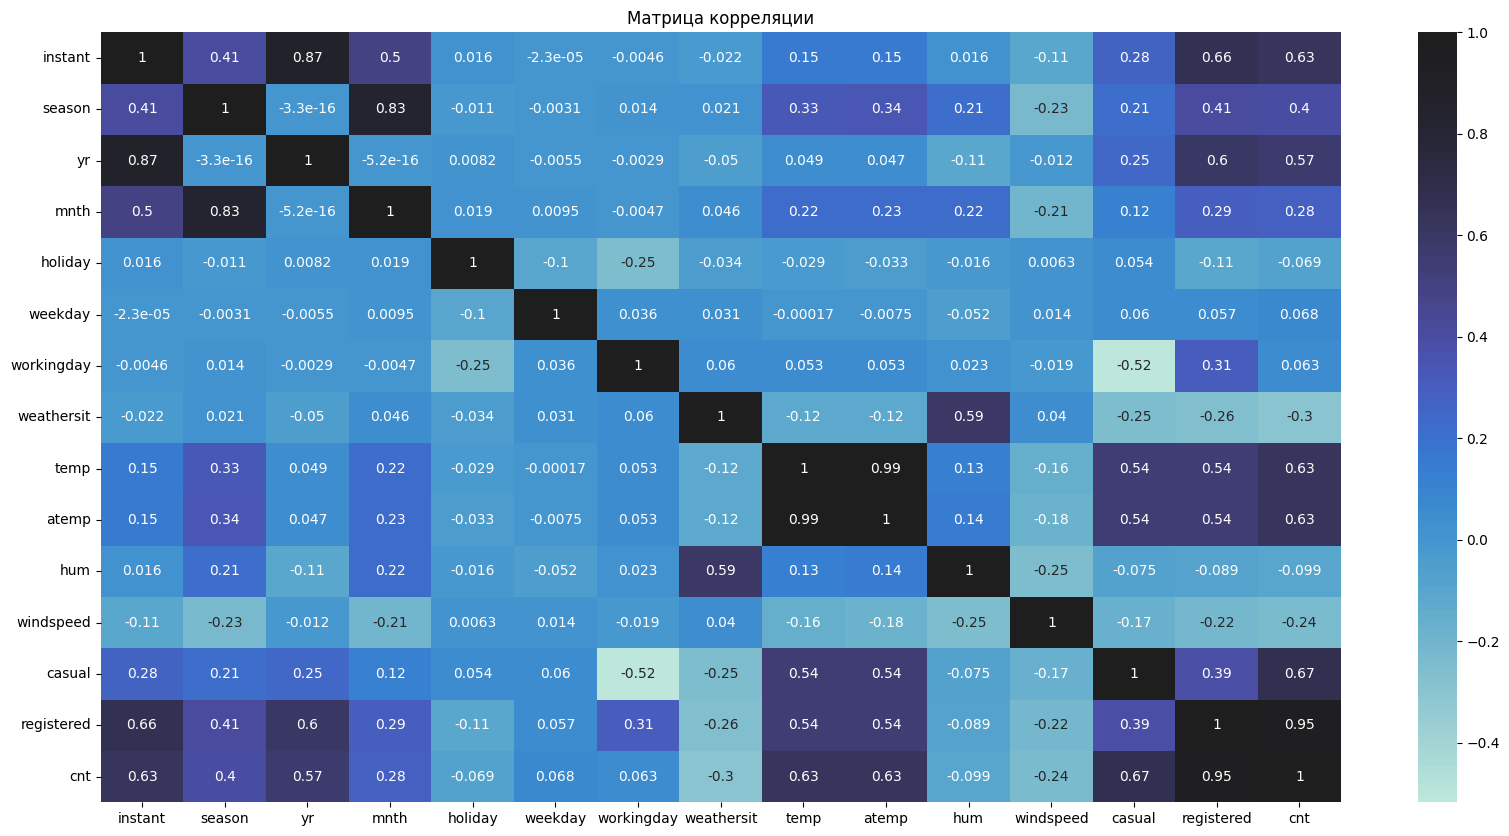

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, center=1)
plt.title('Матрица корреляции')
plt.show()

Сильно коррелируют temp и atemp, registered и cnt, instant и yr, season и month

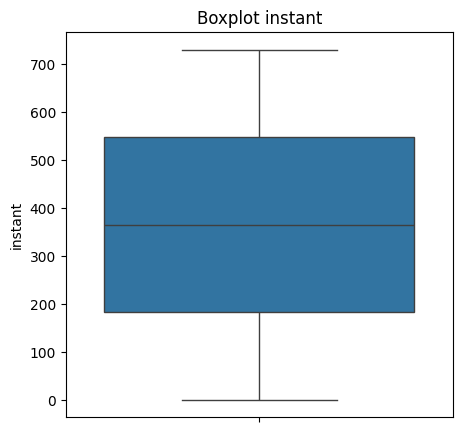

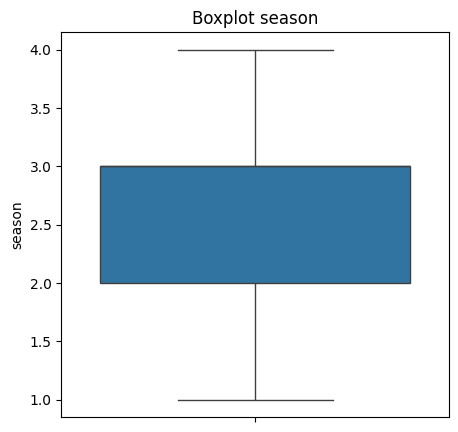

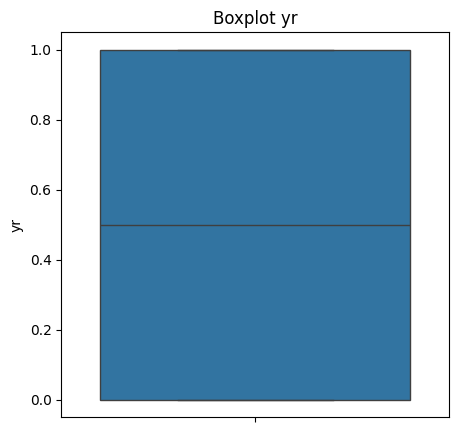

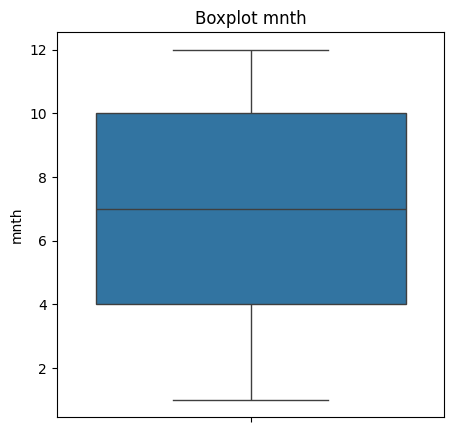

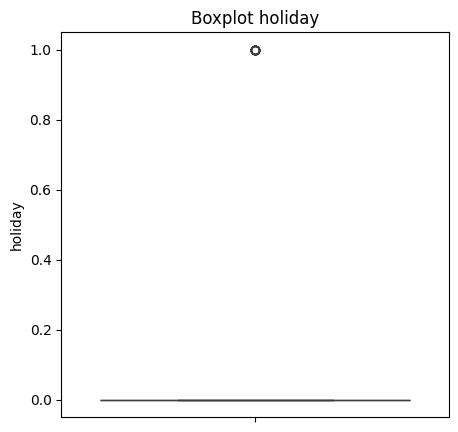

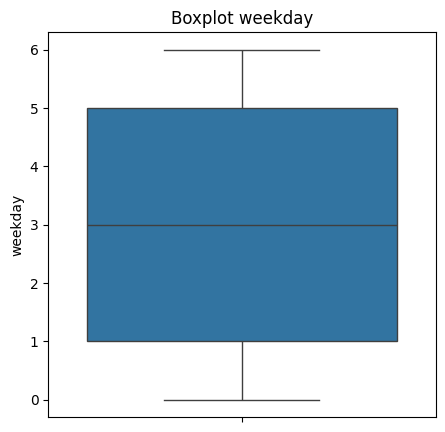

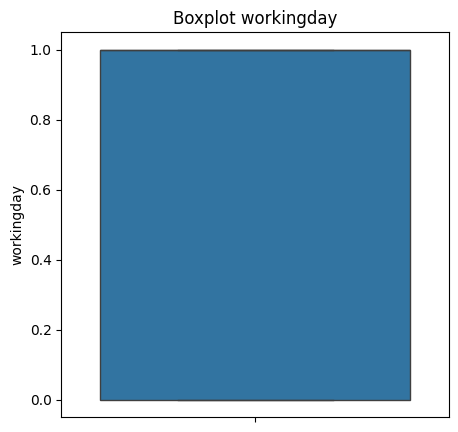

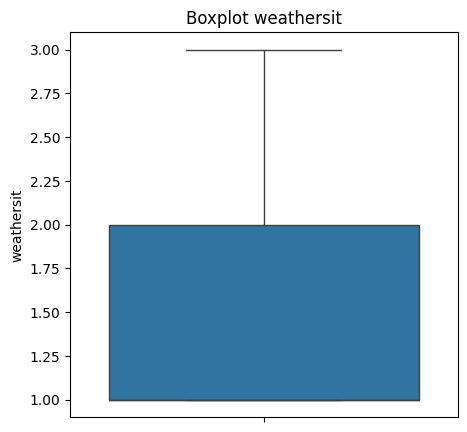

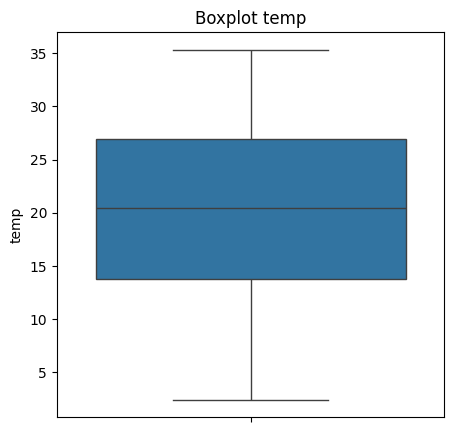

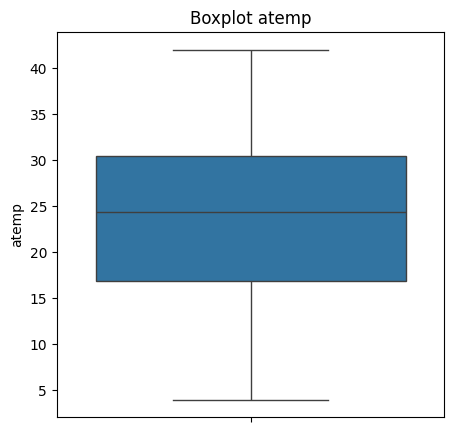

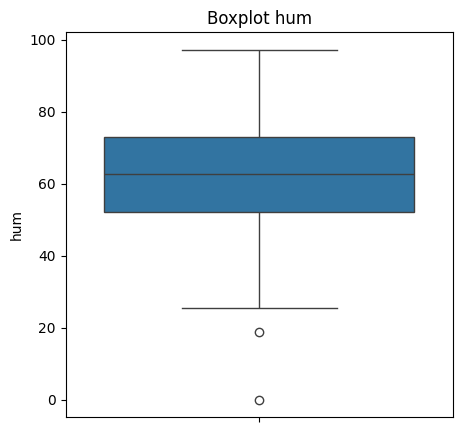

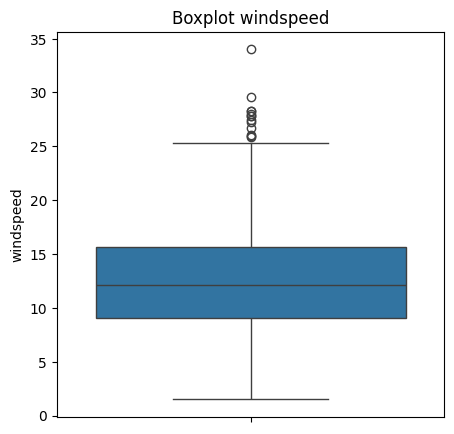

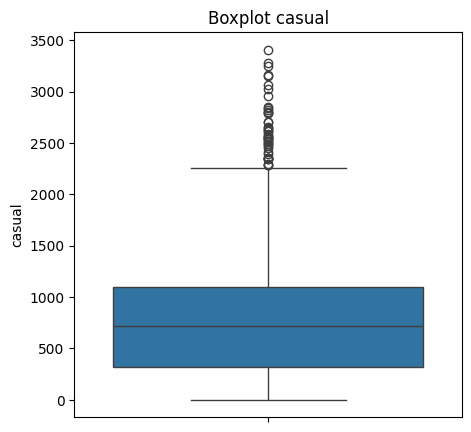

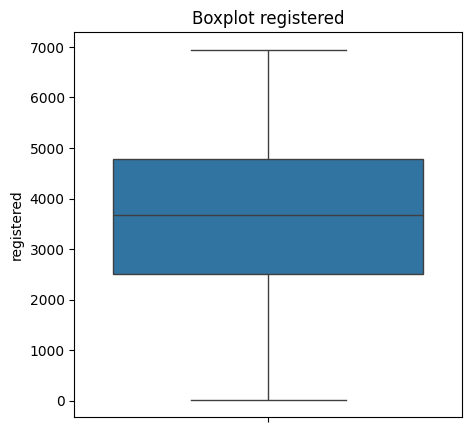

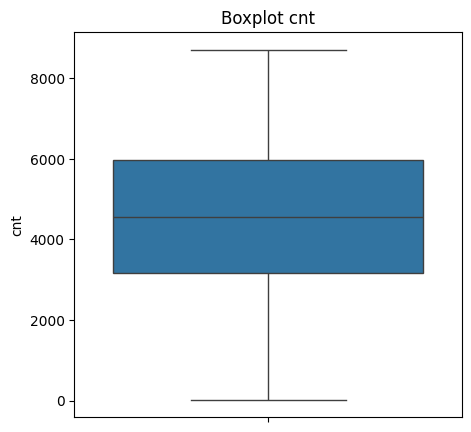

In [59]:
for i in df:
    if i != 'dteday':
        plt.figure(figsize=(5, 5))
        sns.boxplot(data=df[i])
        plt.title(f'Boxplot {i}')
        plt.show()

Выбросы не нужны для dteday, тк это подряд идущие даты
Выбросы есть у holiday, но там либо 0, либо 1, 1 очень редко(
Еще выбросы есть у windspeed, casual

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import datetime
def func(value):
    return time.mktime(datetime.datetime.strptime(value,"%d-%m-%Y").timetuple())
df['dteday'] = df['dteday'].apply(func)
x = df.drop(columns=['cnt'])
y = df['cnt']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

model = LinearRegression()
model.fit(x_train, y_train)

print('Веса всех признаков: ', model.coef_)
print('Свободный коэффицент уравнения w0:', model.intercept_)
print('cnt = ', end='')
arr = []
for i, j in enumerate(model.coef_):
    arr.append(f'{j} * {x.columns[i]}')
s = ' + '
print(s.join(arr))

Веса всех признаков:  [-1.35043919e-17  8.13151629e-20 -2.32224836e-13 -2.33587603e-12
 -1.61485309e-13 -1.45131455e-13  4.96223911e-15  1.98889257e-14
  1.19607981e-13 -4.15636702e-14 -2.05143962e-14  7.47874085e-15
  4.64707910e-15  1.00000000e+00  1.00000000e+00]
Свободный коэффицент уравнения w0: -1.2369127944111824e-10
cnt = -1.3504391931258116e-17 * instant + 8.131516293641283e-20 * dteday + -2.322248361241177e-13 * season + -2.3358760251409124e-12 * yr + -1.6148530937595216e-13 * mnth + -1.451314551629599e-13 * holiday + 4.962239107164202e-15 * weekday + 1.988892569447661e-14 * workingday + 1.19607981085292e-13 * weathersit + -4.1563670215836317e-14 * temp + -2.0514396201324494e-14 * atemp + 7.478740850005309e-15 * hum + 4.6470790961090445e-15 * windspeed + 1.0000000000000002 * casual + 1.0000000000000002 * registered


In [61]:
df1 = pd.DataFrame(model.coef_, columns=['Coefficient'])
df1['features'] = x_train.columns
print(df1.sort_values(by='Coefficient'))

     Coefficient    features
5  -3.734106e-13     holiday
2  -3.003253e-13      season
8  -1.737436e-13  weathersit
12 -1.260915e-14   windspeed
6  -1.146109e-14     weekday
11 -8.205759e-15         hum
10 -7.958902e-15       atemp
1   2.710505e-20      dteday
0   4.536758e-18     instant
9   2.117094e-14        temp
7   5.758465e-14  workingday
4   1.265225e-13        mnth
3   4.713207e-13          yr
14  1.000000e+00  registered
13  1.000000e+00      casual


По матрице корреляции мы угадали только casual и registered

In [62]:
y_pred = model.predict(x_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 score:', r2_score(y_test, y_pred))

Mean Absolute Error: 1.4716994746154404e-12
Mean Squared Error: 3.534934157397881e-24
R2 score: 1.0


Значения ошибок приближенны к нулю, а r2 вообще 1, что просто идеально

Нормализация

In [74]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd

mmsc = MinMaxScaler()
x_norm = mmsc.fit_transform(x_train)

model = LinearRegression()
model.fit(x_norm, y_train)

print('Веса всех признаков: ', model.coef_)
print('Свободный коэффицент: ', model.intercept_)
print('cnt = ', end='')
arr = []
for i, j in enumerate(model.coef_):
    arr.append(f'{j} * {x.columns[i]}')
s = ' + '
print(s.join(arr))

y_pred = model.predict(x_norm)
print('Mean Absolute Error: ', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error: ', mean_squared_error(y_train, y_pred))
print('R2: ', r2_score(y_train, y_pred))

Веса всех признаков:  [ 5.89086209e+01 -5.89086209e+01 -2.21689334e-12  4.54747351e-12
  7.10542736e-12  3.15925064e-12 -2.81552559e-13  1.67688086e-12
 -6.27053964e-13  4.06430445e-12 -1.90425453e-12  3.32356365e-12
 -1.77635684e-13  3.28100000e+03  6.92600000e+03]
Свободный коэффицент:  21.99999999999818
cnt = 58.908620883827666 * instant + -58.9086208838346 * dteday + -2.2168933355715126e-12 * season + 4.547473508864641e-12 * yr + 7.105427357601002e-12 * mnth + 3.1592506388733455e-12 * holiday + -2.815525590449397e-13 * weekday + 1.6768808563938364e-12 * workingday + -6.270539643082884e-13 * weathersit + 4.064304448547773e-12 * temp + -1.9042545318370685e-12 * atemp + 3.3235636465178686e-12 * hum + -1.7763568394002505e-13 * windspeed + 3281.0000000000005 * casual + 6925.999999999992 * registered
Mean Absolute Error:  1.0152765777473893e-12
Mean Squared Error:  2.052625609641336e-24
R2:  1.0


По итогу, значения ошибок и точности не поменялись, но коэффиценты уравнения очень сильно изменились в непонятную сторону. Ну а так у моей замечательной модели все просто замечательно